<a href="https://colab.research.google.com/github/MaximeSzymanski/VAE_pytorch/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# get mnist dataÀà

import torchvision
from torchvision import datasets, transforms


In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
def image_to_tensor(image_path):
    img = Image.open(image_path).convert('RGB')
    resize = transforms.Resize((64, 64))
    img = resize(img)
    img = transforms.ToTensor()(img)
    return img

# get all path in the folder and subfolders
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder = 'images/augmented'
# get all file apth in the folder
files = []
for r, d, f in os.walk(folder):
    for file in f:
        if '.png' in file:
            files.append(os.path.join(r, file))
print(f"Number of files: {len(files)}")
list_dataset = []
for file in files:
    list_dataset.append(image_to_tensor(file))
tranining_dataset = torch.stack(list_dataset)

Number of files: 20000


size of the dataset: torch.Size([20000, 3, 64, 64])


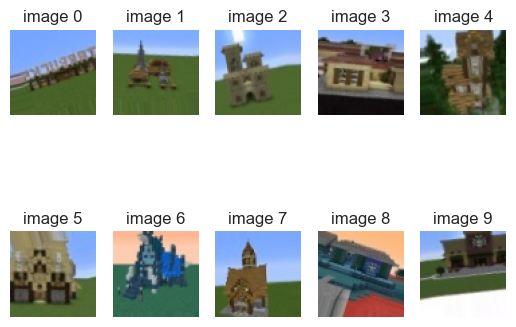

In [3]:
print(f'size of the dataset: {tranining_dataset.shape}')
# plot the 10 first images
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(tranining_dataset[i].permute(1,2,0))
    plt.axis('off')
    plt.title(f"image {i}")

In [4]:
# keep only percentage of the training set
percentage = 0.1
n = int(percentage*len(tranining_dataset))
print(f"number of images kept: {n}")
training_dataset = tranining_dataset[:n]


number of images kept: 2000


In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(64*16*16, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):
        # x: batch_size * 1 * 28 * 28
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 64 * 28 * 28
        # flatten
        print(f"shape before flatten: {x.shape}")
        x = x.view(-1, 64*16*16)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        x = self.fc2(x)
        # x: batch_size * latent_dim
        return x

In [6]:
encoder = Encoder(1, 128, 2)

In [7]:
first_imgae = training_dataset[0].unsqueeze(0)
encoded = encoder(first_imgae)
print(f"shape of the encoded image: {encoded.shape}")

shape before flatten: torch.Size([1, 64, 16, 16])
shape of the encoded image: torch.Size([1, 2])


shape before flatten: torch.Size([10, 64, 16, 16])
shape before flatten: torch.Size([10, 64, 16, 16])


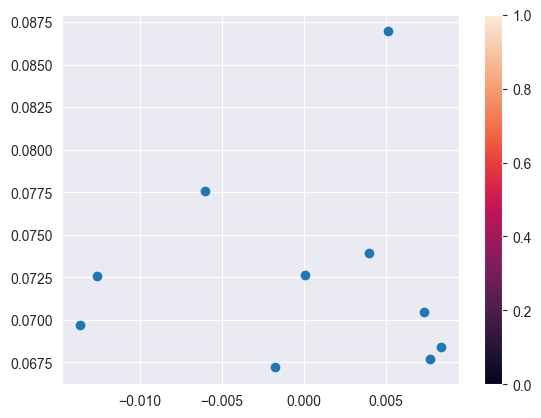

In [8]:
# encode the first 10 images
images = training_dataset[:10]
encoder(images)
# plot the encoded images in 2D
encoded_images = encoder(images).detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1])
plt.colorbar()
plt.show()

In [68]:
class SamplingLayer(torch.nn.Module):
    def __init__(self):
        super(SamplingLayer, self).__init__()

    def forward(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

class VariationalEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        self.bn1 = torch.nn.BatchNorm2d(32)  # Batch Normalization after the first convolution
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0)
        self.bn2 = torch.nn.BatchNorm2d(64)  # Batch Normalization after the second convolution
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0)
        self.bn3 = torch.nn.BatchNorm2d(128)  # Batch Normalization after the third convolution
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(1152, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar = torch.nn.Linear(hidden_dim, latent_dim)
        self.sampling = SamplingLayer()
        # init logvar to 0
        self.logvar.weight.data.fill_(0)
        self.logvar.bias.data.fill_(0)

    def forward(self, x):
        original_x = x
        x = self.conv1(x)
        #x = self.bn1(x)  # Apply Batch Normalization
        x = self.max_pool(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv2(x)
        #x = self.bn2(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv3(x)
        #x = self.bn3(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = torch.nn.Flatten(start_dim=1)(x)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        mu = self.mu(x)
        sigma = self.logvar(x)
        z = self.sampling(mu, sigma)
        # print the shape
        """print(f'original_x: {original_x.shape}')
        print(f'mu: {mu.shape}')
        print(f'sigma: {sigma.shape}')
        print(f'z: {z.shape}')"""

        # x: batch_size * latent_dim
        return z, mu, sigma, original_x
class VariationalDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VariationalDecoder, self).__init__()
        self.save_global_z = torch.nn.Linear(latent_dim, 256)
        self.save_state1 = torch.nn.Linear(256, 15*15*1)
        self.save_state2 = torch.nn.Linear(256, 31*31*1)
        self.save_state3 = torch.nn.Linear(256, 64*64*1)

        self.retrieve_state1 =torch.nn.Conv2d(1, 64, kernel_size=1, stride=1, padding=0)
        self.retrieve_state2 =torch.nn.Conv2d(1, 32, kernel_size=1, stride=1, padding=0)
        self.retrieve_state3 =torch.nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)



        self.fc2 = torch.nn.Linear(latent_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 128 * 7 * 7)  # Reverse of the last fully connected layer in the encoder
        self.deconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0)
        self.bn4 = torch.nn.BatchNorm2d(64)  # Batch Normalization after the first transposed convolution
        self.deconv2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0)
        self.bn5 = torch.nn.BatchNorm2d(32)  # Batch Normalization after the second transposed convolution
        self.deconv3 = torch.nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0)
        self.bn6 = torch.nn.BatchNorm2d(3)  # Batch Normalization after the third transposed convolution

    def forward(self, z):
        global_z = self.save_global_z(z)
        save_state1 = self.save_state1(global_z).view(-1, 1, 15, 15)
        save_state2 = self.save_state2(global_z).view(-1, 1, 31, 31)
        save_state3 = self.save_state3(global_z).view(-1, 1, 64, 64)
        x = self.fc2(z)
        x = self.fc3(x)
        x = x.view(-1, 128, 7, 7)  # Reshape to match the shape after the last convolution in the encoder

        x = self.deconv1(x)
        x = x + self.retrieve_state1(save_state1)
        x = self.bn4(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.deconv2(x)
        x = x + self.retrieve_state2(save_state2)

        x = self.bn5(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.deconv3(x)

        x = x + self.retrieve_state3(save_state3)


        x = torch.nn.functional.sigmoid(x)  # You can use sigmoid for the final layer to ensure pixel values in [0, 1]

        return x




In [69]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z, mu, sigma, original_x = self.encoder(x)
        x = self.decoder(z)
        return x, mu, sigma, original_x

In [70]:
encoder = VariationalEncoder(1, 128, 64)

first_image = training_dataset[0].unsqueeze(0)
encoded_first_image,_,_,_ = encoder(first_image)
decoder = VariationalDecoder(64, 128, 1)
decoded = decoder(encoded_first_image)
print(f"shape of the decoded image: {decoded.shape}")

shape of the decoded image: torch.Size([1, 3, 64, 64])


In [71]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(original_x, x):


    return torch.nn.functional.binary_cross_entropy(x, original_x, reduction='sum')

def loss_function(x, original_x, mu, sigma,k1=1,k2=3e-4):

    return k1 *reconstruction_loss(original_x, x) + k2 * KL_loss(mu, sigma)

In [72]:

variational_autoencoder = VariationalAutoEncoder(1, 512, 512)
variational_autoencoder.to(device)
print(variational_autoencoder)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1152, out_features=512, bias=True)
    (mu): Linear(in_features=512, out_features=512, bias=True)
    (logvar): Linear(in_features=512, out_features=512, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (save_global_z): Linear(in_features=512, out_features=256, bias=True)
    (save_state1): Linear(in_features=256, out_feat

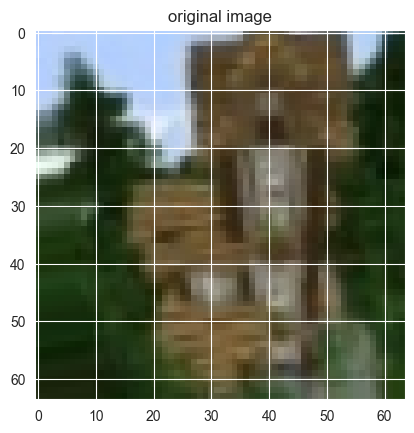

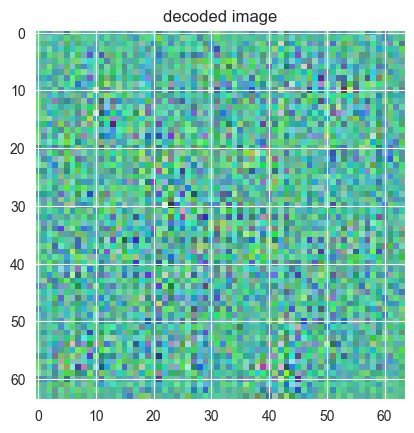

In [73]:
# encode the first 10 images
images = training_dataset[:10].float()
images = images.to(device)

encoded,_,_,_= variational_autoencoder.encoder(images)
decoded = variational_autoencoder.decoder(encoded)

# plot the original image, and the decoded images
plt.imshow(images[4].cpu().detach().permute(1, 2, 0))
# add title
plt.title("original image")
plt.show()
plt.imshow(decoded[4].cpu().detach().permute(1, 2, 0))
plt.title("decoded image")
plt.show()



In [74]:
# save the model

In [75]:
batch_size = 16
lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=lr)
# put data into dataloader
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/ipykernel_69756/2440783852.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))


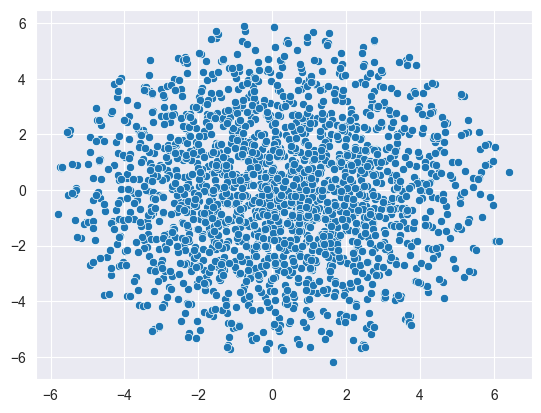

In [76]:
# check clusters using t-sne
from sklearn.manifold import TSNE
import seaborn as sns
with torch.no_grad():
    images = training_dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)
    decoded = variational_autoencoder.decoder(encoded[0])

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

    encoded_data_2d = TSNE(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))
plt.show()

In [77]:
def train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0

        for i, (images) in enumerate(training_dataloader):
            # plot the first image of the first batch

            # check if images is full of 0
            images = images.float()
            # count number of non 0 in the tensor


            images = images.to(device)
            x, mu, sigma, original_x = variational_autoencoder(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss/len(training_dataloader.dataset)}')


In [58]:
train(10000)

Epoch: 1, Loss: 7504.57816015625
Epoch: 2, Loss: 6918.21889453125
Epoch: 3, Loss: 6794.662859375
Epoch: 4, Loss: 6726.6642109375
Epoch: 5, Loss: 6695.66298046875
Epoch: 6, Loss: 6667.82854296875
Epoch: 7, Loss: 6641.99565625
Epoch: 8, Loss: 6625.878515625
Epoch: 9, Loss: 6603.80861328125
Epoch: 10, Loss: 6596.278265625
Epoch: 11, Loss: 6582.38384375
Epoch: 12, Loss: 6571.92536328125
Epoch: 13, Loss: 6571.73875
Epoch: 14, Loss: 6562.01826953125
Epoch: 15, Loss: 6548.604859375
Epoch: 16, Loss: 6545.433546875
Epoch: 17, Loss: 6537.23019921875
Epoch: 18, Loss: 6532.98691796875
Epoch: 19, Loss: 6527.2804375
Epoch: 20, Loss: 6523.397734375
Epoch: 21, Loss: 6518.8660390625
Epoch: 22, Loss: 6510.11002734375
Epoch: 23, Loss: 6504.70609765625
Epoch: 24, Loss: 6505.01813671875
Epoch: 25, Loss: 6497.18550390625
Epoch: 26, Loss: 6496.0868828125
Epoch: 27, Loss: 6493.8744609375
Epoch: 28, Loss: 6488.70585546875
Epoch: 29, Loss: 6488.41638671875
Epoch: 30, Loss: 6483.18017578125
Epoch: 31, Loss: 6478

KeyboardInterrupt: 

torch.Size([2000, 3, 64, 64])


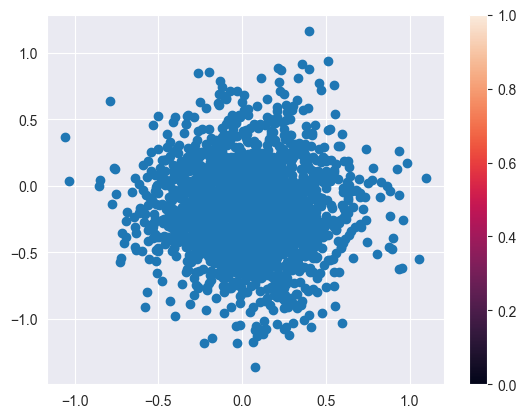

In [61]:
# take all images from the train set
with torch.no_grad():
  # encode the first 10 images
    print(training_dataloader.dataset.shape)
    images = training_dataloader.dataset.float()
    images = images.to(device)
    # plot the encoded images in 2D

    encoded_images, _ , _ ,_  = variational_autoencoder.encoder(images)
    encoded_images = encoded_images.cpu().detach().numpy()
    plt.scatter(encoded_images[:, 0], encoded_images[:, 1])
    plt.colorbar()
    plt.show()


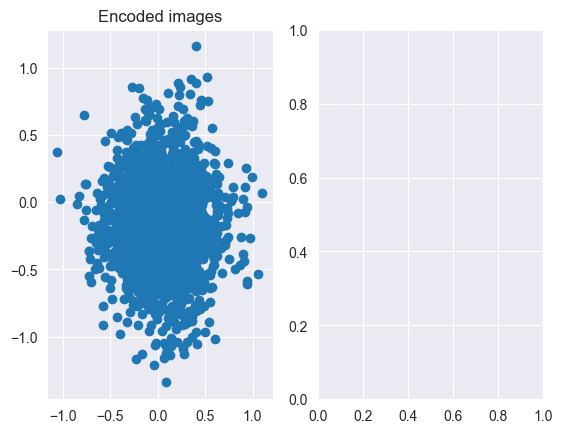

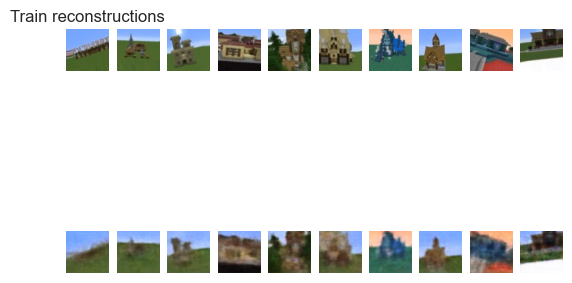

In [62]:
import torch
import matplotlib.pyplot as plt

# Take 10 images from the train set
with torch.no_grad():
    images = training_dataloader.dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()
    f, ax_arr = plt.subplots(1, 2)
    ax_arr[0].scatter(encoded_images[:, 0], encoded_images[:, 1])
    ax_arr[0].set_title('Encoded images')



    # Plot the decoded images in a 2 by 5 grid, with the original images on top of each decoded image
    f, axarr = plt.subplots(2, 10)

    # Get the first 10 images
    random_images_train = training_dataloader.dataset.float()[:10].float()
    random_images_train = random_images_train.to(device)
    # Encode the whole images
    encoded_train, _, _, _ = variational_autoencoder.encoder(random_images_train)

    decoded_train = variational_autoencoder.decoder(encoded_train)
    # Decode the whole images and plot them
    axarr[0, 0].set_title('Train reconstructions')

    for i in range(10):
        # Remove the axis ticks
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        # name it train
        # Plot the original images in black and white
        axarr[0, i].imshow(random_images_train[i].cpu().detach().permute(1, 2, 0))

        axarr[1, i].imshow(decoded_train[i].cpu().detach().permute(1, 2, 0))


    # Do the same for the test set





/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/ipykernel_69756/1962336135.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))


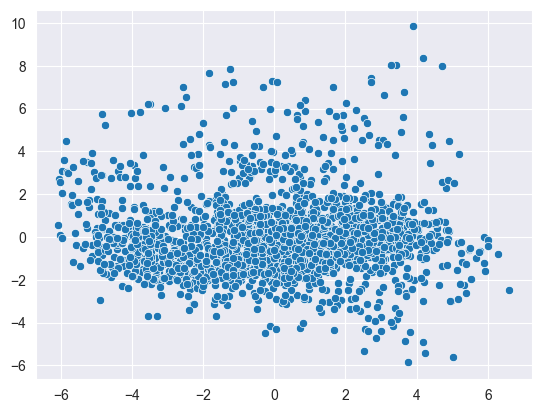

In [63]:
# do same with PCA
from sklearn.decomposition import PCA
with torch.no_grad():
    images = training_dataloader.dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = PCA(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], legend='full', palette=sns.color_palette("hls", 10))
plt.show()

/Users/maximeszymanski/PycharmProjects/MinecraftScrapping/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/ipykernel_69756/354555657.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=kmeans.labels_, legend='full', palette=sns.color_palette("hls", 10))


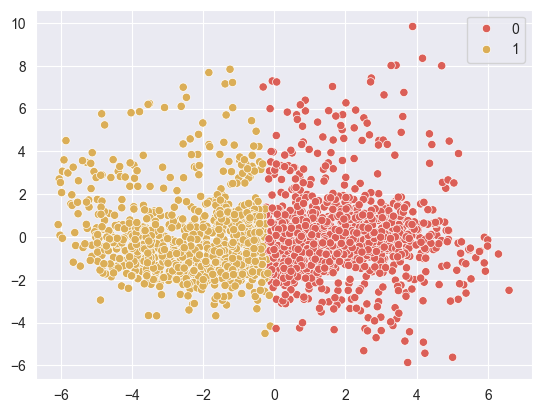

cluster 1 size: 1097
cluster 2 size: 903


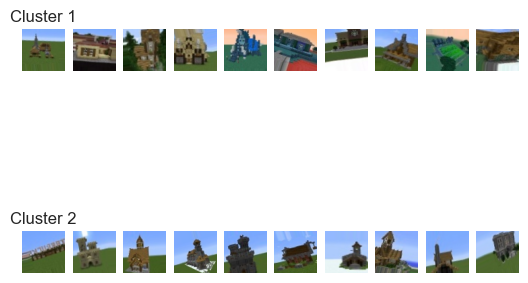

In [64]:
# cliuster using kmeans after PCA

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_data_2d)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=kmeans.labels_, legend='full', palette=sns.color_palette("hls", 10))
plt.show()

# plot 10 images from each cluster

cluster_1 = []
cluster_2 = []
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        cluster_1.append(i)
    else:
        cluster_2.append(i)
print(f"cluster 1 size: {len(cluster_1)}")
print(f"cluster 2 size: {len(cluster_2)}")
# plot 10 images from each cluster
f, axarr = plt.subplots(2, 10)
# put title
axarr[0, 0].set_title('Cluster 1')
axarr[1, 0].set_title('Cluster 2')
for i in range(10):
    # Remove the axis ticks
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')
    # name it train
    # Plot the original images in black and white
    axarr[0,i].imshow(images[cluster_1[i]].cpu().detach().permute(1, 2, 0))

    axarr[1,i].imshow(images[cluster_2[i]].cpu().detach().permute(1, 2, 0))


/Users/maximeszymanski/PycharmProjects/MinecraftScrapping/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/x7/9x2xrn891jxgf18qzxbzyd_m0000gn/T/ipykernel_69756/2817695775.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=kmeans.labels_, legend='full', palette=sns.color_palette("hls", 10))


cluster 1 size: 1145
cluster 2 size: 855


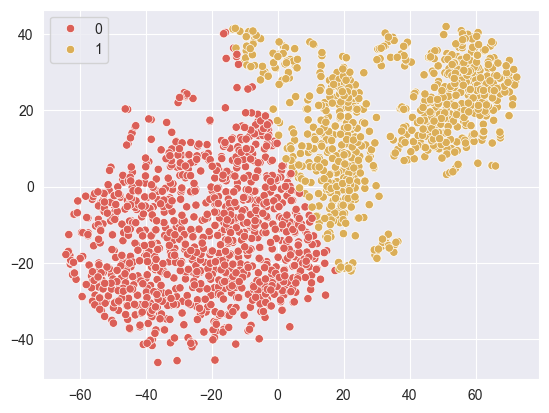

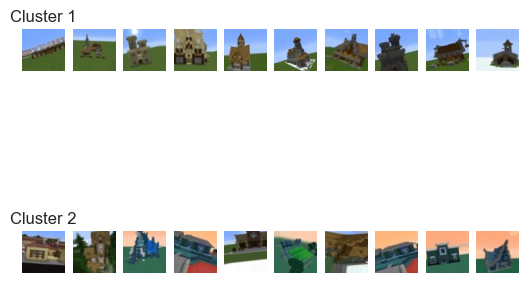

In [65]:
# encode images, turn into 2d latent space using TSNE, cluster using kmeans, plot 10 images from each cluster
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

with torch.no_grad():
    images = training_dataloader.dataset.float()
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = TSNE(n_components=2).fit_transform(encoded_images)
kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_data_2d)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=kmeans.labels_, legend='full', palette=sns.color_palette("hls", 10))
# plot 10 images from each cluster

cluster_1 = []
cluster_2 = []
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        cluster_1.append(i)
    else:
        cluster_2.append(i)
print(f"cluster 1 size: {len(cluster_1)}")
print(f"cluster 2 size: {len(cluster_2)}")
# plot 10 images from each cluster
f, axarr = plt.subplots(2, 10)
# put title
axarr[0, 0].set_title('Cluster 1')
axarr[1, 0].set_title('Cluster 2')

for i in range(10):
    # Remove the axis ticks
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')
    # name it train
    # Plot the original images in black and white
    axarr[0,i].imshow(images[cluster_1[i]].cpu().detach().permute(1, 2, 0))

    axarr[1,i].imshow(images[cluster_2[i]].cpu().detach().permute(1, 2, 0))

plt.show()

shape : torch.Size([1, 3, 64, 64])


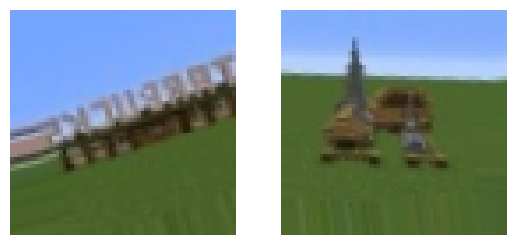

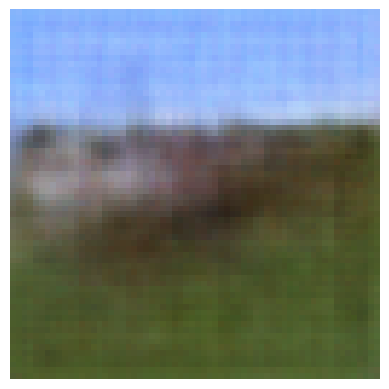

In [67]:
with torch.no_grad():
  # Plot the decoded images in a 2 by 5 grid, with the original images on top of each decoded image


    # Get the first 10 images
    random_images_train_0 = training_dataloader.dataset[0].unsqueeze(0).float().to(device)
    random_images_train_5 = training_dataloader.dataset[1].unsqueeze(0).float().to(device)
    print(f"shape : {random_images_train_0.shape}")
    # Encode the whole images
    encoded_train_0, _, _, _ = variational_autoencoder.encoder(random_images_train_0)
    encoded_train_5, _, _, _ = variational_autoencoder.encoder(random_images_train_5)

    # compute the mean of the two encoded images to get the latent space representation of the sum of the two images
    sum_0_5 = (encoded_train_0 + encoded_train_5) / 2
    # Decode the latent space representation of the sum of the two images


    decoded_train = variational_autoencoder.decoder(sum_0_5)
    decoded_train = decoded_train.squeeze()
    # Plot the decoded test images


    # Plot the decoded test images
    f, axarr = plt.subplots(1, 2)


    axarr[0].axis('off')
    axarr[1].axis('off')

    random_images_train_0 = random_images_train_0.squeeze()
    random_images_train_5 = random_images_train_5.squeeze()

    # Plot the original images in black and white
    axarr[0].imshow(random_images_train_0.cpu().detach().permute(1, 2, 0))

    axarr[1].imshow(random_images_train_5.cpu().detach().permute(1, 2, 0))

    # Plot the decoded test images
    f, axarr = plt.subplots(1, 1)
    axarr.axis('off')
    axarr.imshow(decoded_train.cpu().detach().permute(1, 2, 0))
    plt.savefig("sum_0_5.png")
    plt.show()
# save decoded_train in a file




In [ ]:
!pip install -q optuna

In [ ]:
# lets use optuna to find the best hyperparameters
import optuna
from optuna.trial import TrialState

def define_model(trial):
    # create the Variational Autoencoder
    hidden_dim = 256
    latent_size = trial.suggest_int('latent_size', 2, 200)

    model = VariationalAutoEncoder(input_dim=1,hidden_dim=hidden_dim, latent_dim=latent_size)
    return model



def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    k1 =1
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    k2 = trial.suggest_float('k2', 1e-5, 1)
    # Training of the model.
    for epoch in range(20):
        epoch_loss = 0
        model.train()
        for images, _ in mnist_trainloader:
            images = images.to(device)
            x, mu, sigma, original_x = model(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma,k1=k1,k2=k2)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        trial.report(epoch_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return epoch_loss/len(mnist_trainloader.dataset)

In [ ]:

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))